### 了解kmeans, white等基本概念

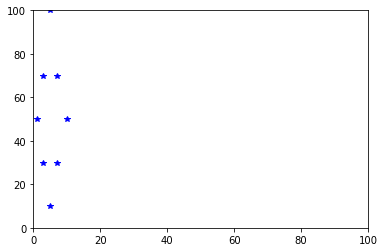

In [1]:
import numpy as np
import matplotlib.pyplot as plt

obs = np.array([
    [1, 5],
    [3, 7],
    [5, 10],
    [7, 7],
    [10, 5],
    [7, 3],
    [5, 1],
    [3, 3]
])
obs[:, 1] *= 10
max_val = obs.max()
plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.plot(obs[:, 0], obs[:, 1], "b*")

array([[0.37504578, 1.87522892],
       [1.12513735, 2.62532049],
       [1.87522892, 3.75045785],
       [2.62532049, 2.62532049],
       [3.75045785, 1.87522892],
       [2.62532049, 1.12513735],
       [1.87522892, 0.37504578],
       [1.12513735, 1.12513735]])

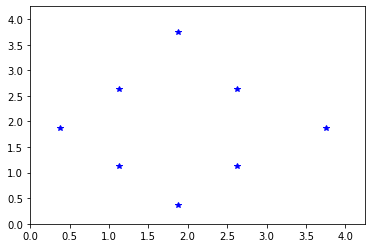

In [2]:
norm_obs = obs / obs.std(axis=0)
max_val = norm_obs.max() + .5
plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.plot(norm_obs[:, 0], norm_obs[:, 1], "b*")
norm_obs

In [3]:
from scipy.cluster.vq import whiten
from scipy.cluster.vq import kmeans

whiten(obs), norm_obs

(array([[0.37504578, 1.87522892],
        [1.12513735, 2.62532049],
        [1.87522892, 3.75045785],
        [2.62532049, 2.62532049],
        [3.75045785, 1.87522892],
        [2.62532049, 1.12513735],
        [1.87522892, 0.37504578],
        [1.12513735, 1.12513735]]),
 array([[0.37504578, 1.87522892],
        [1.12513735, 2.62532049],
        [1.87522892, 3.75045785],
        [2.62532049, 2.62532049],
        [3.75045785, 1.87522892],
        [2.62532049, 1.12513735],
        [1.87522892, 0.37504578],
        [1.12513735, 1.12513735]]))

### rewrite kmeans

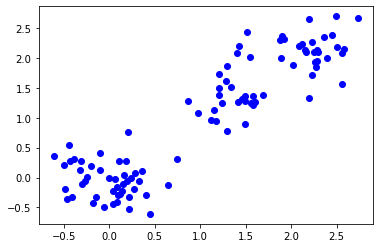

In [59]:
data0 = np.random.randn(100, 2)
data0[:30] += 3.0
data0[:55] += 5.0
data = data0 / data0.std(0)
plt.scatter(data[:, 0], data[:, 1], c='b')

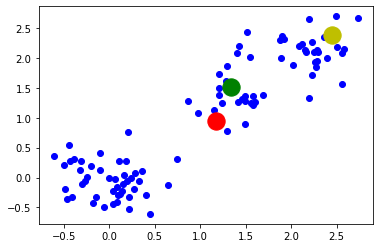

In [60]:
k = 3
center_index = np.random.choice(np.arange(len(data)), k)
center = data[center_index]
plt.scatter(data[:, 0], data[:, 1], c='b')
plt.scatter(center[0, 0], center[0, 1], c="r", s=300)
plt.scatter(center[1, 0], center[1, 1], c="g", s=300)
plt.scatter(center[2, 0], center[2, 1], c="y", s=300)

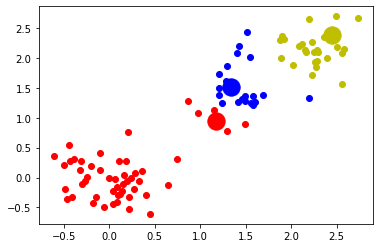

In [61]:
# 距离等于 (p1 - p2)^2
# p1 => n x 2
# p2 => center => 3 x 2
# 利用广播机制相减的话，得做出一个长度为1的维度：
# (n,1,2) - (1,3,2) = n x 3 x 2
datax = data[:, None]
centerx = center[None]
distance = ((datax - centerx) ** 2).sum(axis=(2))
# 得到每个点离三个点的哪一点的距离最小（索引） -> n
data_class = distance.argmin(axis=1) # [0, 0, 2, 1, ...]
# 跟谁近就设为跟谁一组
c0 = data_class == 0
c1 = data_class == 1
c2 = data_class == 2
plt.scatter(data[c0, 0], data[c0, 1], c='r')
plt.scatter(data[c1, 0], data[c1, 1], c='b')
plt.scatter(data[c2, 0], data[c2, 1], c='y')

plt.scatter(center[0, 0], center[0, 1], c="r", s=300)
plt.scatter(center[1, 0], center[1, 1], c="b", s=300)
plt.scatter(center[2, 0], center[2, 1], c="y", s=300)

Automatic pdb calling has been turned OFF
diff: 1.8748588280243401
diff: 0.08189252632213272
diff: 0.0017729116500026004
diff: 0.0012538561305721124
diff: 0.0


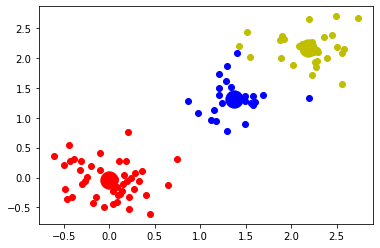

In [62]:
%pdb
# 每个类别求平均值，当成新的质心
for _ in range(100):
    center_0 = data[c0].mean(axis=0, keepdims=True) # 对x,y分别求平均，即axis=0
    center_1 = data[c1].mean(axis=0, keepdims=True)
    center_2 = data[c2].mean(axis=0, keepdims=True)
    new_center = np.vstack((center_0, center_1, center_2))
    diff = ((new_center - center) ** 2).sum()
    center = new_center
    print('diff:', diff)
    if diff < 1e-5: break
    datax = data[:, None]
    centerx = new_center[None]
    distance = ((datax - centerx) ** 2).sum(axis=(2))
    data_class = distance.argmin(axis=1)

    c0 = data_class == 0
    c1 = data_class == 1
    c2 = data_class == 2
plt.scatter(data[c0, 0], data[c0, 1], c='r')
plt.scatter(data[c1, 0], data[c1, 1], c='b')
plt.scatter(data[c2, 0], data[c2, 1], c='y')

plt.scatter(new_center[0, 0], new_center[0, 1], c="r", s=300)
plt.scatter(new_center[1, 0], new_center[1, 1], c="b", s=300)
plt.scatter(new_center[2, 0], new_center[2, 1], c="y", s=300)

### 总结

就是每次确定目标点的时候，比如k个，所有样本距离这k个点总有一个距离最短的，那么就可以分类了

**但是**

目的并不是为了分类，而只是演示了可以用**自定义条件**生成k组新数据，比如这里就是生成了三组center

我们后面就是要用一千多组数据，来生成9组anchor（是每条数据生成9组吗？试验后回答）

看下面的试验，kmeans函数分明是返回了三个质心，也就是说不是自定义，而是真在无监督训练，返回了几个质心，
用的就是随机指定几个质心，
然后再把每个点跟几个质心的距离做对比，找到每个点距离最近的质心，初次分类
然后再把分类好的群取平均值得到新的质心，再进行上一步距离对比，如此往复
退出标识为一定次数的循环后，或上下两次质心的diff很小

### 调包

In [65]:
# data already been whitened
k, a = kmeans(data, 3)
k.sort(0), new_center.sort(0)
k, new_center

(array([[-0.00291044, -0.04306037],
        [ 1.37424748,  1.31944446],
        [ 2.18539114,  2.16204562]]),
 array([[-0.00291044, -0.04306037],
        [ 1.37424748,  1.31944446],
        [ 2.18539114,  2.16204562]]))